<a href="https://colab.research.google.com/github/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/blob/main/MV_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Objective: Predict Monthly Crude Palm Oil Price Using Convolutional Neural Network (CNN)

In [4]:
!pip install scikeras
!pip install bayesian-optimization
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 KB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.4 MB/s eta 0:00:00


###Load Libraries

In [5]:
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(1)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer, mean_squared_error
from keras.layers import Dense, Dropout
from sklearn.metrics import explained_variance_score
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold, cross_val_score
from scikeras.wrappers import KerasRegressor
from tensorflow import keras
from kerastuner.tuners import RandomSearch
from kerastuner import HyperModel, RandomSearch, Hyperband, BayesianOptimization
from keras.callbacks import EarlyStopping
from time import time
import pickle

import matplotlib.dates as mdates
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

###Define Functions to Facilitate Metrics Evaluation

In [6]:
#To compute Mean Directional Accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

#Calculate the Mean Absolute Percentage Error
#def MAPE(y_true, y_pred): 
    #mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    #return mape

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Calculate the Root Mean Squared Error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

###Load the Cleaned Data from Github

In [7]:
from pandas import read_csv
path = 'https://raw.githubusercontent.com/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/main/Cleaned_data/FS_2.csv'
df = read_csv(path)
df.head()

,date,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
0,12/1/10,323,455,3102.61,423.45,844.0,468.0,578.0
1,1/1/11,345,546,3100.45,415.85,799.0,485.0,557.0
2,2/1/11,362,595,3199.41,410.77,718.0,466.0,552.0
3,3/1/11,376,636,3281.67,414.82,614.0,442.0,574.0
4,4/1/11,383,738,3261.65,451.04,619.0,429.0,595.0


In [8]:
df['date']=pd.to_datetime(df['date'])
#del df['date']

In [9]:
df.set_index('date', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 124 entries, 2010-12-01 to 2021-03-01
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cpo_pri  124 non-null    int64  
 1   cno_pri  124 non-null    int64  
 2   oli_pri  124 non-null    float64
 3   rps_pri  124 non-null    float64
 4   pno_pri  124 non-null    float64
 5   sbo_pri  124 non-null    float64
 6   sfo_pri  124 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 7.8 KB


In [10]:
df.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2010-12-01,323,455,3102.61,423.45,844.0,468.0,578.0
2011-01-01,345,546,3100.45,415.85,799.0,485.0,557.0
2011-02-01,362,595,3199.41,410.77,718.0,466.0,552.0
2011-03-01,376,636,3281.67,414.82,614.0,442.0,574.0
2011-04-01,383,738,3261.65,451.04,619.0,429.0,595.0


<Figure size 1800x720 with 0 Axes>

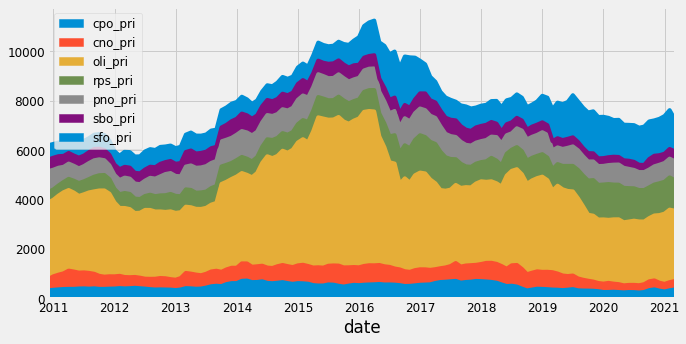

In [11]:
# Plot an area chart
plt.figure(figsize=(25,10))
ax = df.plot.area(fontsize=12);

# Additional customizations
ax.set_xlabel('date');
ax.legend(fontsize=12);

##**Convolutional Neural Network Forecasting Technique (CNN)**

###**Split Data into Train Test Segments**

In [12]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print('Train size:',len(train))
print('Test size:', len(test))

Train size: 99
Test size: 25


In [13]:
split_date = '2019-02'
df_training = df.loc[df.index <= split_date]
df_test = df.loc[df.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

99 days of training data 
 25 days of testing data 


In [14]:
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

99 25


In [15]:
print(train.shape)
train.head()

(99, 7)


,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2010-12-01,323,455,3102.61,423.45,844.0,468.0,578.0
2011-01-01,345,546,3100.45,415.85,799.0,485.0,557.0
2011-02-01,362,595,3199.41,410.77,718.0,466.0,552.0
2011-03-01,376,636,3281.67,414.82,614.0,442.0,574.0
2011-04-01,383,738,3261.65,451.04,619.0,429.0,595.0


###Rescaling Training Data

In [16]:
f_transformer = MinMaxScaler()
feature_columns = ['cno_pri', 'oli_pri', 'rps_pri', 'pno_pri', 'sbo_pri', 'sfo_pri']
f_transformer = f_transformer.fit(train[feature_columns].to_numpy())
train.loc[:, feature_columns] = f_transformer.transform(train[feature_columns].to_numpy())
train.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2010-12-01,323,0.112288,0.140918,0.010736,0.528090,0.253193,0.023302
2011-01-01,345,0.305085,0.140327,0.004301,0.443820,0.306536,0.009321
2011-02-01,362,0.408898,0.167408,0.000000,0.292135,0.246917,0.005992
2011-03-01,376,0.495763,0.189919,0.003429,0.097378,0.171609,0.020639
2011-04-01,383,0.711864,0.184440,0.034095,0.106742,0.130817,0.034621


In [17]:
cpo_pri_transformer = MinMaxScaler()
cpo_pri_transformer = cpo_pri_transformer.fit(train[['cpo_pri']])
train['cpo_pri'] = cpo_pri_transformer.transform(train[['cpo_pri']])
train['cpo_pri'].head()

date
2010-12-01    0.0100
2011-01-01    0.0650
2011-02-01    0.1075
2011-03-01    0.1425
2011-04-01    0.1600
Name: cpo_pri, dtype: float64

In [18]:
test.loc[:, feature_columns] = f_transformer.transform(test[feature_columns].to_numpy())
test.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2019-03-01,354,0.637712,0.194855,0.382454,0.381292,-0.039662,0.493342
2019-04-01,348,0.533898,0.264388,0.393951,0.213633,-0.054975,0.597870
2019-05-01,332,0.400424,0.246417,0.453802,0.235262,-0.092159,0.606525
2019-06-01,349,0.317797,0.234308,0.509834,0.320749,-0.074743,0.631824
2019-07-01,372,0.313559,0.223422,0.526454,0.426610,-0.066114,0.773462


In [19]:
test['cpo_pri'] = cpo_pri_transformer.transform(test[['cpo_pri']])
test['cpo_pri'].head()

date
2019-03-01    0.0875
2019-04-01    0.0725
2019-05-01    0.0325
2019-06-01    0.0750
2019-07-01    0.1325
Name: cpo_pri, dtype: float64

###Create X_train, y_train, X_test and y_test

In [61]:
def createDataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        data = X.iloc[i:(i + time_steps)].values
        Xs.append(data)        
        ys.append(y.iloc[i + time_steps])
        
    return np.array(Xs), np.array(ys)

time_steps = 3
X_train, y_train = createDataset(train, train.cpo_pri, time_steps)
X_test, y_test = createDataset(test, test.cpo_pri, time_steps)
print(X_train.shape, y_train.shape)

(96, 3, 7) (96,)


In [19]:
#test_lag = test[1:23]
#len(test) - 1

In [20]:
#decrement naturally.
#shifted = test.set_index(["date"]).unstack().shift(3).stack()

In [66]:
cnn_model = tf.keras.Sequential()
cnn_model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='tanh', input_shape=(X_test.shape[1], X_test.shape[2])))
cnn_model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dense(64, activation='tanh'))
cnn_model.add(tf.keras.layers.Dense(1))

# compile model using adam
cnn_model.compile(optimizer='adam',loss='mse',metrics=['mse'])
# model training
history = cnn_model.fit(X_train, y_train, epochs=100, batch_size = 64, validation_split=0.2) #epochs = 30, batch_size = 60

# model evaluation
cnn_model.evaluate(X_test, y_test)


#cnn_model.compile(loss='mse', optimizer='adam')
#cnn_model.summary()
#bst -> epochs = 300, batch_size = 128, RMSE = 32
#bst -> epochs = 350, batch_size = 100, RMSE = 36
#bst -> epochs = 400, batch_size = 128, RMSE = 39

Epoch 1/100
2/2 [==============================] - 1s 172ms/step - loss: 0.3969 - mse: 0.3969 - val_loss: 0.3596 - val_mse: 0.3596
Epoch 2/100
2/2 [==============================] - 0s 24ms/step - loss: 0.1270 - mse: 0.1270 - val_loss: 0.1954 - val_mse: 0.1954
Epoch 3/100
2/2 [==============================] - 0s 24ms/step - loss: 0.0535 - mse: 0.0535 - val_loss: 0.1904 - val_mse: 0.1904
Epoch 4/100
2/2 [==============================] - 0s 20ms/step - loss: 0.1008 - mse: 0.1008 - val_loss: 0.2072 - val_mse: 0.2072
Epoch 5/100
2/2 [==============================] - 0s 19ms/step - loss: 0.1333 - mse: 0.1333 - val_loss: 0.1846 - val_mse: 0.1846
Epoch 6/100
2/2 [==============================] - 0s 26ms/step - loss: 0.1098 - mse: 0.1098 - val_loss: 0.1489 - val_mse: 0.1489
Epoch 7/100
2/2 [==============================] - 0s 21ms/step - loss: 0.0662 - mse: 0.0662 - val_loss: 0.1298 - val_mse: 0.1298
Epoch 8/100
2/2 [==============================] - 0s 21ms/step - loss: 0.0362 - mse: 0.0

[0.016009200364351273, 0.016009200364351273]

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


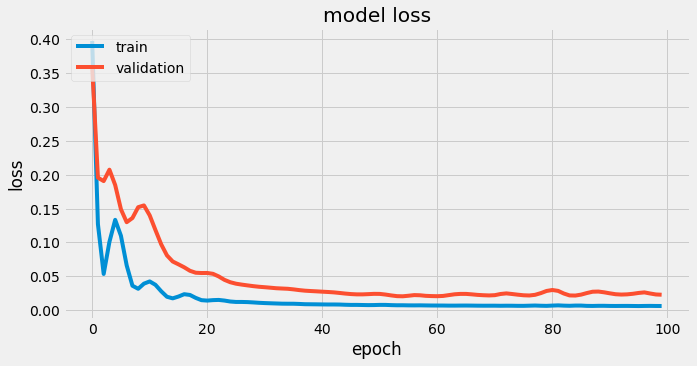

In [67]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [68]:
mse_cnn = cnn_model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 20ms/step - loss: 0.0160 - mse: 0.0160


####Baseline MSE = 0.01660

In [69]:
cnn_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 2, 64)             960       
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 64)                4160      
                                                                 
 dense_20 (Dense)            (None, 1)                 65        
                                                                 
Total params: 5,185
Trainable params: 5,185
Non-trainable params: 0
____________________________________________________

###Predict the Test without Hyperparameter Tuning

In [71]:
y_pred = cnn_model.predict(X_test)
y_pred

1/1 [==============================] - 0s 85ms/step


array([[ 0.07322033],
       [ 0.05568712],
       [ 0.09894419],
       [ 0.09893896],
       [ 0.0606476 ],
       [ 0.05969106],
       [ 0.06603254],
       [ 0.04280656],
       [-0.00405691],
       [-0.02903455],
       [-0.0352555 ],
       [-0.02256324],
       [-0.04664466],
       [-0.05229891],
       [-0.04521763],
       [-0.06062226],
       [-0.08137361],
       [ 0.01145878],
       [ 0.10789619],
       [ 0.14502743],
       [ 0.05264865],
       [ 0.05490379]], dtype=float32)

In [72]:
y_pred.reshape(1,-1)

array([[ 0.07322033,  0.05568712,  0.09894419,  0.09893896,  0.0606476 ,
         0.05969106,  0.06603254,  0.04280656, -0.00405691, -0.02903455,
        -0.0352555 , -0.02256324, -0.04664466, -0.05229891, -0.04521763,
        -0.06062226, -0.08137361,  0.01145878,  0.10789619,  0.14502743,
         0.05264865,  0.05490379]], dtype=float32)

###Invert Transformed Data

In [73]:
y_train_inv = cpo_pri_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cpo_pri_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cpo_pri_transformer.inverse_transform(y_pred.reshape(1,-1))
print(y_train_inv)
print(y_test_inv)
print(y_pred_inv)

[[376. 383. 382. 396. 402. 390. 404. 382. 382. 391. 396. 413. 401. 410.
  425. 408. 392. 371. 356. 362. 356. 352. 333. 357. 411. 404. 387. 395.
  434. 488. 508. 494. 575. 614. 616. 707. 719. 655. 661. 687. 625. 611.
  631. 655. 616. 586. 615. 607. 590. 535. 518. 519. 562. 552. 508. 476.
  513. 545. 532. 550. 561. 567. 580. 559. 562. 553. 533. 498. 504. 525.
  547. 556. 566. 621. 659. 671. 688. 705. 633. 661. 674. 703. 694. 681.
  663. 632. 561. 497. 509. 475. 392. 319. 354. 388. 381. 370.]]
[[349. 372. 324. 315. 312. 306. 288. 255. 257. 265. 254. 240. 254. 251.
  234. 255. 330. 362. 310. 277. 323. 360.]]
[[348.28812 341.27487 358.57767 358.5756  343.25903 342.87643 345.41302
  336.12262 317.37723 307.38617 304.8978  309.9747  300.34213 298.08044
  300.91296 294.7511  286.45056 323.5835  362.15848 377.01096 340.05948
  340.96152]]


###Plot History, Actual and Predicted Value

In [74]:
y_train_inv = y_train_inv.flatten()
y_train_inv

array([376., 383., 382., 396., 402., 390., 404., 382., 382., 391., 396.,
       413., 401., 410., 425., 408., 392., 371., 356., 362., 356., 352.,
       333., 357., 411., 404., 387., 395., 434., 488., 508., 494., 575.,
       614., 616., 707., 719., 655., 661., 687., 625., 611., 631., 655.,
       616., 586., 615., 607., 590., 535., 518., 519., 562., 552., 508.,
       476., 513., 545., 532., 550., 561., 567., 580., 559., 562., 553.,
       533., 498., 504., 525., 547., 556., 566., 621., 659., 671., 688.,
       705., 633., 661., 674., 703., 694., 681., 663., 632., 561., 497.,
       509., 475., 392., 319., 354., 388., 381., 370.])

In [75]:
y_test_inv = y_test_inv.flatten()
y_test_inv

array([349., 372., 324., 315., 312., 306., 288., 255., 257., 265., 254.,
       240., 254., 251., 234., 255., 330., 362., 310., 277., 323., 360.])

In [76]:
y_pred_inv = y_pred_inv.flatten()
y_pred_inv

array([348.28812, 341.27487, 358.57767, 358.5756 , 343.25903, 342.87643,
       345.41302, 336.12262, 317.37723, 307.38617, 304.8978 , 309.9747 ,
       300.34213, 298.08044, 300.91296, 294.7511 , 286.45056, 323.5835 ,
       362.15848, 377.01096, 340.05948, 340.96152], dtype=float32)

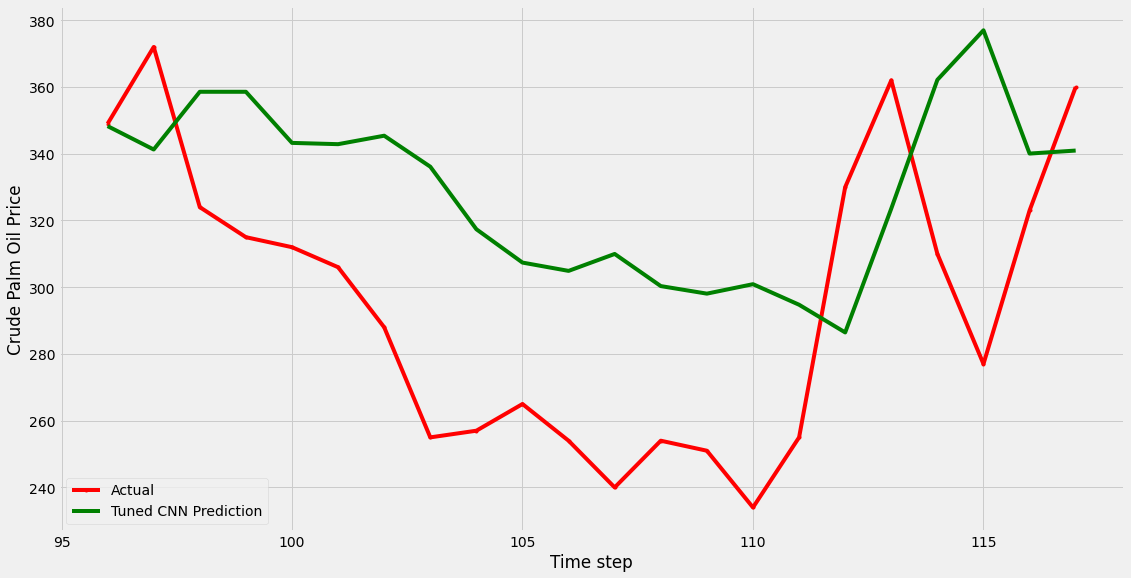

In [77]:
plt.figure(figsize=(17,9))
#plt.grid()
#plt.plot(np.arange(0, len(y_train)), y_train_inv, color='green', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, color='red', marker='.', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv, color='green', label="Tuned CNN Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('Time step')
plt.legend()
ax.grid()
#plt.grid()
#plt.show();

###Evaluate CNN Model Accuracy

In [78]:
MAE_cnn = mean_absolute_error(y_test_inv, y_pred_inv)
print('MAE value of the CNN Model is:', MAE_cnn)

MDA_cnn = mda(y_test_inv, y_pred_inv)
print('MDA value of the CNN Model is:', MDA_cnn)

MAPE_cnn = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
print('MAPE value of the CNN Model is:', MAPE_cnn)

RMSE_cnn = mean_squared_error(y_test_inv,y_pred_inv, squared=False)
print('RMSE value of the CNN Model is:', RMSE_cnn)

MSE_cnn = mean_squared_error(y_test_inv,y_pred_inv)
print('MSE value of the CNN Model is:', MSE_cnn)

#EVS_cnn = explained_variance_score(y_test_inv, y_pred_inv)
#print('EVS score of the CNN Model is:', EVS_cnn)

MAE value of the CNN Model is: 45.91896611993963
MDA value of the CNN Model is: 0.38095238095238093
MAPE value of the CNN Model is: 16.543863128058412
RMSE value of the CNN Model is: 50.610988567114426
MSE value of the CNN Model is: 2561.4721637405873


###Tuning CNN with Keras Tuner

Define A Model-Building Class

In [79]:
class ANNhypermodel(HyperModel):
#class CNNHyperModel(HyperModel):
    
    def __init__(self, input_shape):
        self.input_shape= input_shape
        
    def build(self, hp):
        model= keras.Sequential()
        
        # Tune the number of units in the first Dense layer
        # Defining dense units as a close approx to the original neural network to perform a fair comparision!
        
        
        hp_units_1= hp.Int('units_1', min_value=128, max_value= 160, step=32)
        hp_units_2= hp.Int('units_2', min_value=64, max_value= 128, step=32)
        hp_units_3= hp.Int('units_3', min_value=32, max_value= 64, step=16)
        hp_units_4= hp.Int('units_4', min_value=16, max_value= 32, step=8)

        model.add(keras.layers.Dense(units=hp_units_1, activation='tanh', input_shape= self.input_shape))
        model.add(keras.layers.Dense(units=hp_units_2, activation='tanh'))
        model.add(keras.layers.Dense(units=hp_units_3, activation='tanh'))
        model.add(keras.layers.Dense(units=hp_units_4, activation='tanh'))
        model.add(keras.layers.Dense(1))
        #Tune the dropout
        model.add(
            Dropout(
                rate=hp.Float(
                    'dropout',
                    min_value=0.0,
                    max_value=0.5,
                    default=0.25,
                    step=0.05
                )
            )
        )
        
        # Tune the epoch for the optimizer

        #batch_size = hp.Int('batch_size',8,16,24,32,40,48,56,64,72,80,88,96, step=8)
        
        optimizers = hp.Choice('optimizer',values=['rmsprop','adam','sgd','adadelta','adagrad'])

        # Tune the batch size for the optimizer 
        hp_batch_size = hp.Int('batch_size', min_value = 8, max_value = 96, step = 8, default=8)
        
        # Tune the epoch for the optimizer
        hp_epoch = hp.Int('epoch', min_value = 5, max_value = 100, step = 5, default=5)

        # Tune the learning rate for the optimizer 
        hp_learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default= 0.0005)
       # -------------------------------------------------------
        model.compile(loss='mse',
                    optimizer= keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    metrics= ['mae','mse']
                     )

        return model

hypermodel= ANNhypermodel(input_shape = (X_test.shape[1], X_test.shape[2]))
#hypermodel = CNNHyperModel(input_shape = (X_test.shape[1], X_test.shape[2]))

###Build Random Search Tuner

In [80]:
tuner_rs = RandomSearch(
            hypermodel,
            objective='mse',
            seed=42,
            max_trials=10,
            executions_per_trial=2, overwrite=True
        )

###Run Random Search

In [82]:
tuner_rs.search(X_train, y_train, epochs=16, validation_split=0.2, verbose=0)

###Evaluate Random Search

In [83]:
best_model = tuner_rs.get_best_models(num_models=1)[0]
mse_rs = best_model.evaluate(X_test, y_test)[1]

1/1 [==============================] - 0s 351ms/step - loss: 0.2349 - mae: 0.4721 - mse: 0.2349


####Random Search MSE = 0.2369

In [84]:
best_params = tuner_rs.get_best_hyperparameters()

best_params[0].values

{'units_1': 128,
 'units_2': 96,
 'units_3': 32,
 'units_4': 16,
 'dropout': 0.0,
 'optimizer': 'sgd',
 'batch_size': 88,
 'epoch': 55,
 'learning_rate': 0.0033137745378583987}

###Build Bayesian Optimization

In [85]:
tuner_bo = BayesianOptimization(
            hypermodel,
            objective='val_mse',
            max_trials=10,
            seed=42,
            executions_per_trial=2,
            directory='bo'
        )

###Run Bayesian Optimization

In [86]:
tuner_bo.search(X_train, y_train, epochs=10, validation_split=0.2, verbose=0)

best_model = tuner_bo.get_best_models(num_models=1)[0]
mse_bo = best_model.evaluate(X_test, y_test)[1]

1/1 [==============================] - 0s 369ms/step - loss: 0.3562 - mae: 0.5867 - mse: 0.3562


###Bayesian Optimization Search MSE = 0.3562

###Evaluate Bayesian Optimization

In [87]:
best_params = tuner_bo.get_best_hyperparameters()

best_params[0].values

{'units_1': 128,
 'units_2': 96,
 'units_3': 32,
 'units_4': 16,
 'dropout': 0.0,
 'optimizer': 'sgd',
 'batch_size': 88,
 'epoch': 55,
 'learning_rate': 0.0033137745378583987}

In [88]:
best_model = tuner_bo.get_best_models(num_models=1)[0]
mse_bo = best_model.evaluate(X_test, y_test)[1]

1/1 [==============================] - 0s 342ms/step - loss: 0.3562 - mae: 0.5867 - mse: 0.3562


###Build HYPERBAND optimization

In [89]:
MAX_TRIALS = 20
tuner= RandomSearch(hypermodel,
               objective= 'val_mse',
               max_trials= MAX_TRIALS,
               executions_per_trial= 2,
               directory= 'random_search',
               project_name='randomsearch',
               overwrite=True)

In [90]:
HYPERBAND_MAX_EPOCHS = 150
EXECUTION_PER_TRIAL = 2

tuner= Hyperband(hypermodel,
                   objective= 'val_mse',
                   max_epochs=HYPERBAND_MAX_EPOCHS, #Set 100+ for good results
                   executions_per_trial=EXECUTION_PER_TRIAL,
                   directory= 'hyperband',
                   project_name='hyper',
                   overwrite=True)

# tuner.search_space_summary()

In [91]:
print('searching for the best params!')

t0 = time()
tuner.search(x= X_train,
             y= y_train,
             epochs=100,
             batch_size= 64,
             validation_data= (X_test, y_test),
             verbose=0,
             callbacks= []
            )
print(time()- t0," secs")

# Retreive the optimal hyperparameters
best_hps= tuner.get_best_hyperparameters(num_trials=1)[0]

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

searching for the best params!
852.1344032287598  secs


In [92]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the 
first densely-connected layer is {best_hps.get('units_1')},
second layer is {best_hps.get('units_2')} 
third layer is {best_hps.get('units_3')} 
fourth layer is {best_hps.get('units_4')}
drop out is {best_hps.get('dropout')}
batch_size is {best_hps.get('batch_size')}
epoch is {best_hps.get('epoch')}
optimizer is {best_hps.get('optimizer')}

#learning rate is {best_hps.get('learning_rate')}                                        

and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

# Evaluate the best model.
print(best_model.metrics_names)
loss, mae, mse = best_model.evaluate(X_test, y_test)
print(f'loss:{loss} mae: {mae} mse: {mse}')


The hyperparameter search is complete. The optimal number of units in the 
first densely-connected layer is 128,
second layer is 96 
third layer is 32 
fourth layer is 24
drop out is 0.0
batch_size is 32
epoch is 55
optimizer is adagrad

#learning rate is 0.009575093678226607                                        

and the optimal learning rate for the optimizer
is 0.009575093678226607.

[]
1/1 [==============================] - 0s 342ms/step - loss: 0.0118 - mae: 0.0954 - mse: 0.0118
loss:0.011848642490804195 mae: 0.09538210183382034 mse: 0.011848642490804195


In [60]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print(best_hps.values)

{'units_1': 128, 'units_2': 64, 'units_3': 64, 'units_4': 24, 'dropout': 0.1, 'optimizer': 'adagrad', 'batch_size': 16, 'epoch': 55, 'learning_rate': 0.006820026103064649, 'tuner/epochs': 6, 'tuner/initial_epoch': 0, 'tuner/bracket': 3, 'tuner/round': 0}


###Apply the trained parameters to the CNN

In [93]:
TUcnn_model = tf.keras.Sequential()
TUcnn_model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=2, activation='tanh', input_shape=(X_test.shape[1], X_test.shape[2])))
TUcnn_model.add(tf.keras.layers.Dense(96, activation='tanh'))
TUcnn_model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
TUcnn_model.add(tf.keras.layers.Flatten())

TUcnn_model.add(tf.keras.layers.Dense(32))
TUcnn_model.add(tf.keras.layers.Dense(24))
TUcnn_model.add(layers.Dropout(0.0))

#Output layer of model
TUcnn_model.add(tf.keras.layers.Dense(1))

In [94]:
TUcnn_model.compile(loss = 'mse', optimizer= tf.keras.optimizers.Adagrad(learning_rate=0.006887291548601745), metrics= ['mae', 'mse'])
#TUcnn_model.compile(optimizer='rmsprop',loss='mse',metrics=['mse']),
history = TUcnn_model.fit(X_train, y_train, epochs=55, batch_size=32,validation_split=0.2,shuffle=False) # 80/160

Epoch 1/55
3/3 [==============================] - 1s 118ms/step - loss: 0.0758 - mae: 0.2173 - mse: 0.0758 - val_loss: 0.2411 - val_mae: 0.3990 - val_mse: 0.2411
Epoch 2/55
3/3 [==============================] - 0s 13ms/step - loss: 0.0646 - mae: 0.1906 - mse: 0.0646 - val_loss: 0.1147 - val_mae: 0.2834 - val_mse: 0.1147
Epoch 3/55
3/3 [==============================] - 0s 16ms/step - loss: 0.0318 - mae: 0.1295 - mse: 0.0318 - val_loss: 0.0581 - val_mae: 0.2147 - val_mse: 0.0581
Epoch 4/55
3/3 [==============================] - 0s 26ms/step - loss: 0.0271 - mae: 0.1361 - mse: 0.0271 - val_loss: 0.0702 - val_mae: 0.2148 - val_mse: 0.0702
Epoch 5/55
3/3 [==============================] - 0s 14ms/step - loss: 0.0347 - mae: 0.1614 - mse: 0.0347 - val_loss: 0.0639 - val_mae: 0.2048 - val_mse: 0.0639
Epoch 6/55
3/3 [==============================] - 0s 24ms/step - loss: 0.0288 - mae: 0.1445 - mse: 0.0288 - val_loss: 0.0416 - val_mae: 0.1709 - val_mse: 0.0416
Epoch 7/55
3/3 [=================

Plot Model Loss

<Figure size 720x360 with 0 Axes>

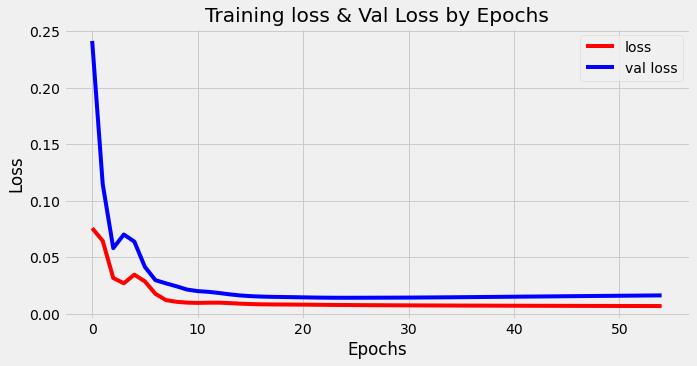

<Figure size 720x360 with 0 Axes>

In [95]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs=range(len(loss)) 


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r',label='loss')
plt.plot(epochs,val_loss,'blue',label='val loss')
plt.title('Training loss & Val Loss by Epochs')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.figure()

In [96]:
y_predTU = TUcnn_model.predict(X_test)
y_predTU

1/1 [==============================] - 0s 84ms/step


array([[ 0.06259444],
       [ 0.03740383],
       [ 0.06160032],
       [ 0.0858883 ],
       [ 0.03423021],
       [ 0.02169613],
       [ 0.02799211],
       [ 0.00750207],
       [-0.04928098],
       [-0.0739178 ],
       [-0.08281939],
       [-0.08908943],
       [-0.08387403],
       [-0.08755323],
       [-0.08535457],
       [-0.0812978 ],
       [-0.12969907],
       [-0.09092173],
       [ 0.01718281],
       [ 0.12697431],
       [ 0.05871803],
       [ 0.03800496]], dtype=float32)

In [97]:
y_predTU.reshape(1,-1)

array([[ 0.06259444,  0.03740383,  0.06160032,  0.0858883 ,  0.03423021,
         0.02169613,  0.02799211,  0.00750207, -0.04928098, -0.0739178 ,
        -0.08281939, -0.08908943, -0.08387403, -0.08755323, -0.08535457,
        -0.0812978 , -0.12969907, -0.09092173,  0.01718281,  0.12697431,
         0.05871803,  0.03800496]], dtype=float32)

###Invert Transformed Tuned Data

In [98]:
y_train_inv = cpo_pri_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cpo_pri_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cpo_pri_transformer.inverse_transform(y_predTU.reshape(1,-1))
print(y_train_inv)
print(y_test_inv)
print(y_pred_inv)

[[376. 383. 382. 396. 402. 390. 404. 382. 382. 391. 396. 413. 401. 410.
  425. 408. 392. 371. 356. 362. 356. 352. 333. 357. 411. 404. 387. 395.
  434. 488. 508. 494. 575. 614. 616. 707. 719. 655. 661. 687. 625. 611.
  631. 655. 616. 586. 615. 607. 590. 535. 518. 519. 562. 552. 508. 476.
  513. 545. 532. 550. 561. 567. 580. 559. 562. 553. 533. 498. 504. 525.
  547. 556. 566. 621. 659. 671. 688. 705. 633. 661. 674. 703. 694. 681.
  663. 632. 561. 497. 509. 475. 392. 319. 354. 388. 381. 370.]]
[[349. 372. 324. 315. 312. 306. 288. 255. 257. 265. 254. 240. 254. 251.
  234. 255. 330. 362. 310. 277. 323. 360.]]
[[344.03778 333.96155 343.64014 353.35532 332.69208 327.67844 330.19684
  322.00082 299.2876  289.4329  285.87225 283.36423 285.45038 283.9787
  284.8582  286.48087 267.1204  282.6313  325.8731  369.78973 342.4872
  334.20197]]


In [99]:
y_train_inv = y_train_inv.flatten()
y_train_inv

array([376., 383., 382., 396., 402., 390., 404., 382., 382., 391., 396.,
       413., 401., 410., 425., 408., 392., 371., 356., 362., 356., 352.,
       333., 357., 411., 404., 387., 395., 434., 488., 508., 494., 575.,
       614., 616., 707., 719., 655., 661., 687., 625., 611., 631., 655.,
       616., 586., 615., 607., 590., 535., 518., 519., 562., 552., 508.,
       476., 513., 545., 532., 550., 561., 567., 580., 559., 562., 553.,
       533., 498., 504., 525., 547., 556., 566., 621., 659., 671., 688.,
       705., 633., 661., 674., 703., 694., 681., 663., 632., 561., 497.,
       509., 475., 392., 319., 354., 388., 381., 370.])

In [100]:
y_test_inv = y_test_inv.flatten()
y_test_inv

array([349., 372., 324., 315., 312., 306., 288., 255., 257., 265., 254.,
       240., 254., 251., 234., 255., 330., 362., 310., 277., 323., 360.])

In [101]:
TU_CNN_Pred = y_pred_inv.flatten()   #y_pred_inv = TU_CNN_Pred
TU_CNN_Pred

array([344.03778, 333.96155, 343.64014, 353.35532, 332.69208, 327.67844,
       330.19684, 322.00082, 299.2876 , 289.4329 , 285.87225, 283.36423,
       285.45038, 283.9787 , 284.8582 , 286.48087, 267.1204 , 282.6313 ,
       325.8731 , 369.78973, 342.4872 , 334.20197], dtype=float32)

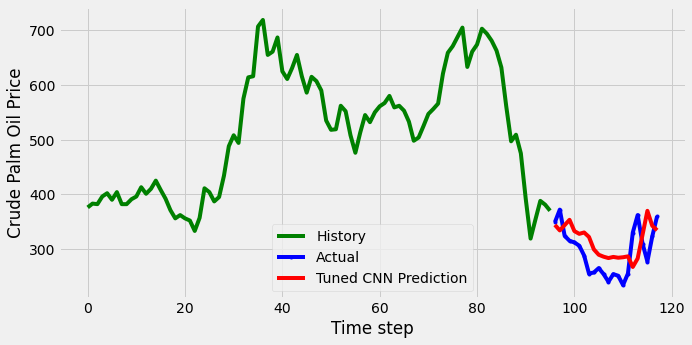

In [102]:
plt.plot(np.arange(0, len(y_train)), y_train_inv, color='green', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, color='blue', marker='.', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), TU_CNN_Pred, color='red', label="Tuned CNN Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('Time step')
plt.legend()
plt.show();

In [103]:
TUMAE_cnn = mean_absolute_error(y_test_inv, TU_CNN_Pred)
print('MAE value of the CNN Model is:', TUMAE_cnn)

TUMDA_cnn = mda(y_test_inv, TU_CNN_Pred)
print('MDA value of the CNN Model is:', TUMDA_cnn)

TUMAPE_cnn = mean_absolute_percentage_error(y_test_inv, TU_CNN_Pred)
print('MAPE value of the CNN Model is:', TUMAPE_cnn)

TURMSE_cnn = mean_squared_error(y_test_inv,TU_CNN_Pred, squared=False)
print('RMSE value of the CNN Model is:', TURMSE_cnn)

TUMSE_cnn = mean_squared_error(y_test_inv,TU_CNN_Pred)
print('MSE value of the CNN Model is:', TUMSE_cnn)

MAE value of the CNN Model is: 38.067536787553266
MDA value of the CNN Model is: 0.42857142857142855
MAPE value of the CNN Model is: 13.328049806756628
RMSE value of the CNN Model is: 43.480641295645675
MSE value of the CNN Model is: 1890.5661674806083


Compare tuned CNN Actual VS Predicted (Zoomed-IN)

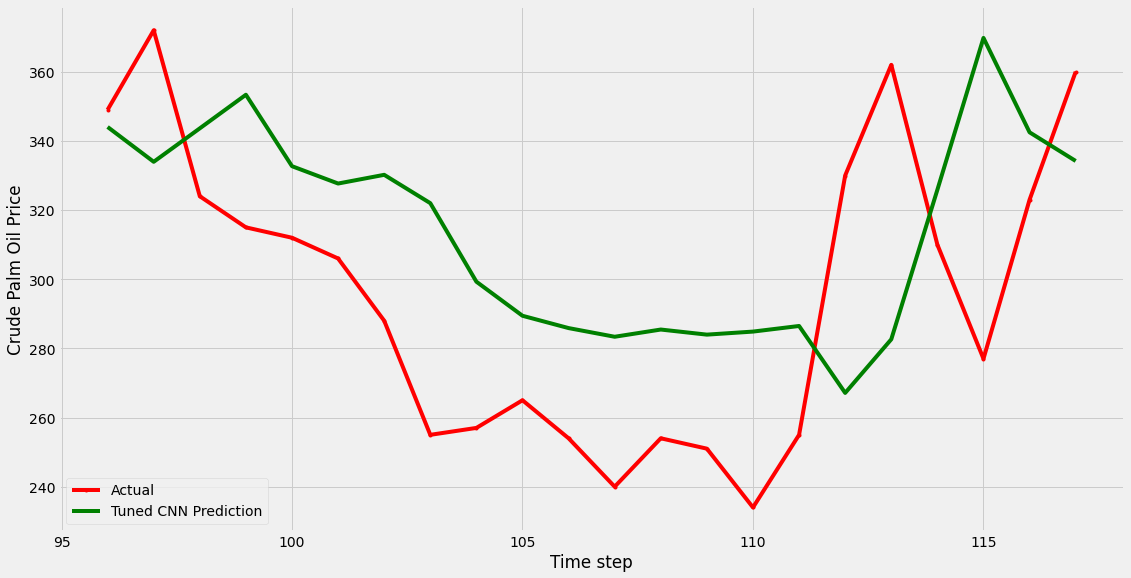

In [104]:
plt.figure(figsize=(17,9))
#plt.grid()
#plt.plot(np.arange(0, len(y_train)), y_train_inv, color='green', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, color='red', marker='.', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), TU_CNN_Pred, color='green', label="Tuned CNN Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('Time step')
plt.legend()
ax.grid()
#plt.grid()
#plt.show();

##Results

Baseline MSE         = 0.0188

Random search MSE    = 0.1198

Bayesian search MSE  = 0.3479

Hyperband search MSE = 0.0114

Baseline RSME        = 54.80

Tuned CNN RSME       = 43.48

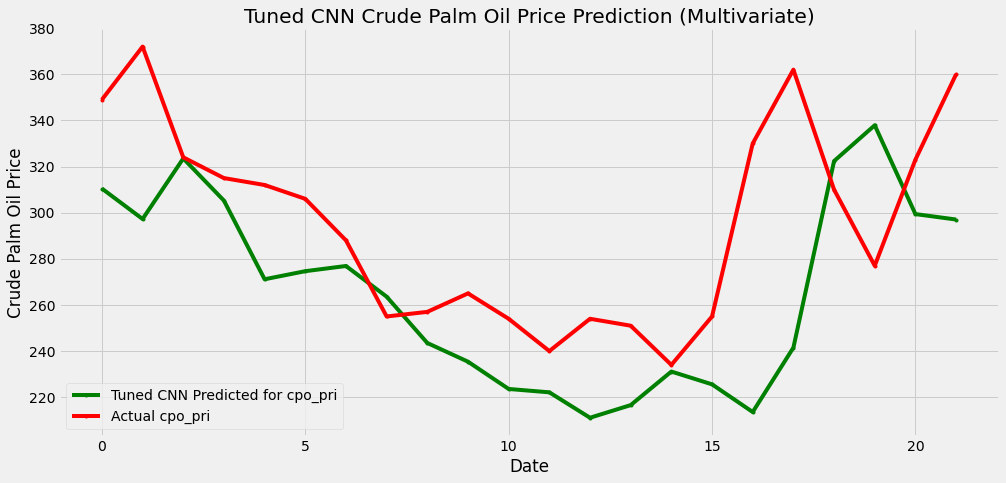

<Figure size 720x360 with 0 Axes>

In [96]:
#Plot the graph between actual vs predicted values
plt.figure(figsize=(15,7))  #(10,6))
plt.plot(TU_CNN_Pred, color= 'green',marker='.',label = 'Tuned CNN Predicted for cpo_pri')
plt.plot(y_test_inv, color = 'red',marker='.',label = 'Actual cpo_pri ')
plt.title("Tuned CNN Crude Palm Oil Price Prediction (Multivariate)")
plt.xlabel("Date")
plt.ylabel("Crude Palm Oil Price")
plt.legend()
plt.show()
plt.savefig('graph_cnn.png')

In [ ]:
dataframe1=pd.DataFrame(y_test_inv, columns=['Actual']) 
print (dataframe1)

    Actual
0    349.0
1    372.0
2    324.0
3    315.0
4    312.0
5    306.0
6    288.0
7    255.0
8    257.0
9    265.0
10   254.0
11   240.0
12   254.0
13   251.0
14   234.0
15   255.0
16   330.0
17   362.0
18   310.0
19   277.0
20   323.0
21   360.0


In [ ]:
dataframe2=pd.DataFrame(TU_CNN_Pred, columns=['TU_CNN_Pred']) 
print (dataframe2)

    TU_CNN_Pred
0    344.218903
1    341.584686
2    353.894501
3    355.339630
4    342.074219
5    335.313416
6    333.718719
7    329.926910
8    309.756226
9    291.540192
10   295.723907
11   301.633362
12   295.315063
13   288.760864
14   291.093109
15   286.227875
16   273.371735
17   289.342834
18   337.855591
19   365.395325
20   342.059265
21   329.132385


In [ ]:
 df.to_csv('actual.csv', index=False)

In [ ]:
df.to_csv('TU_CNN_Pred.csv', index=False)

In [ ]:
  '''
        model.add(
            Dense(
                units=hp.Int(
                    'batch_size',
                    min_value=10,
                    max_value=128,
                    step=16,
                    default=16
                )

            )

       )
       '''

In [ ]:
model.add(
            Dense(
                units=hp.Int(
                    'units',
                    min_value=32,
                    max_value=512,
                    step=32,
                    default=128
                ),

In [ ]:
hp.Float(
                    'learning_rate',
                    min_value=1e-4,
                    max_value=1e-2,
                    sampling='LOG',
                    default=1e-3
                )
            ),